# Simulated Annealing

Let's revisit the shortest path problem discussed previously between the Equestrian Statue and the Bahen Centre, this time using simulated annealing.

Simulated annealing is a probabilistic method of optimizing functions. Named after the process of [annealing metals](https://en.wikipedia.org/wiki/Annealing_(materials_science)), simulated annealing is able to efficiently find a solution that is **close** to the global maximum. At its most basic level, simulated annealing chooses at each step whether to accept a neighbouring state or maintain the same state. While search algorithms like Hill Climbing and Beam Search always reject a neighbouring state with worse results, simulated annealing accepts those "worse" states probabilistically. 

<style>
i {font-weight:normal}
span {font-weight:normal}
</style>

<div style="background-color: rgba(0,0,0,0.0470588);padding:10px;font-family:monospace;">
    <b>SIMULATED-ANNEALING</b>(<i>source</i>,<i>destination</i>, <i>schedule</i>, <i>num_iterations</i>) <b>return</b> a <i>route</i>
    <div style='padding-left:20px;'>
        <i><font color="green">current</font></i> &larr; random <i>route</i> from <i>source</i> to <i>destination</i><br>
        for <i>num_iterations</i> do <br>
        <div style='padding-left:20px;'>
            <font color="orange">T</font></i> &larr; <i>schedule()</i> <br>
            <i><font color="purple">neighbours</font></i> &larr; <i><font color="green">current</font></i>.NEIGHBOURS<br>
            <i><font color="grey">next</font></i> &larr; randomly choose one state from <i><font color="purple">neighbours</font></i><br>
            <i>&Delta;E</i> &larr; <i><font color="grey">next</font></i>.COST - <i><font color="green">current</font></i>.COST<br>
            if <i>&Delta;E</i> < 0 then 
            <div style='padding-left:20px;'>
                <i><font color="green">current</font></i> &larr; <i><font color="grey">next</font></i><br>
            </div>
            else
            <div style='padding-left:20px;'>
                <i><font color="green">current</font></i> &larr; <i><font color="grey">next</font></i> only with probability of e<sup>-&Delta;E/T</sup>
            </div>
        </div>
    <br>
    <i>route</i> &larr; <i><font color="green">current</font></i><br>
    return <i>route</i>
    </div>

</div>
<br><br>

## Schedule
We also need to define an annealing schedule for the algorithm. In metallurgical annealing, the key to a successful annealing is the controlled increase of temperature of a metal to a specified temperature, holding it there for some time, and then cooling it in a controlled fashion. Similarly, the probability of accepting a non-negative &Delta;E changes as the algorithm progresses. At first, there may be a high probability that a clearly inferior neighbour may actually be accepted, as the algorithm considers a wider search space. As the algorithm progresses however, $T$ decreases according to a schedule until it reaches 0.

Below is an example of an annealing schedule:

In [1]:
import numpy as np

def exp_schedule(k=20, lam=0.005, limit=100):
    function = lambda t: (k * np.exp(-lam*t) if t <limit else 0)
    return function

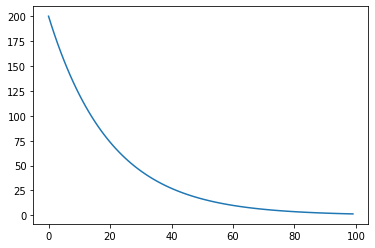

In [2]:
import matplotlib.pyplot as plt
schedule = exp_schedule(200,0.05,10000)
T = [schedule(k) for k in range(100)]
plt.plot(T)

Here is an implementation of simulated annealing in `python` which generates a "shortest" path to solve our problem.

In [3]:
# Setup the Graph, origin, and destination
import osmnx
from smart_mobility_utilities.common import Node
from smart_mobility_utilities.viz import draw_route

reference = (43.661667, -79.395)
G = osmnx.graph_from_point(reference, dist=300, clean_periphery=True, simplify=True)
origin = Node(graph=G, osmid=55808290)
destination = Node(graph=G, osmid=389677909)

In [8]:
from smart_mobility_utilities.common import randomized_search, cost, probability
from smart_mobility_utilities.children import get_children
from tqdm.notebook import tqdm
import random

schedule = exp_schedule(200,0.05,10000)
num_iterations = 100

states = []
current = randomized_search(G, origin.osmid, destination.osmid)

for t in tqdm(range(num_iterations)):
    T = schedule(t)
    states.append(cost(G,current))

    # Generate more paths to choose from
    neighbours = get_children(G,current,num_children=5)
    next_choice = random.choice(neighbours)

    delta_e = cost(G,next_choice) - cost(G,current)
    if delta_e <0 or probability(np.exp(-1 * delta_e/T)):
        current = next_choice

route = current

draw_route(G,route)

  0%|          | 0/100 [00:00<?, ?it/s]

Map(center=[43.6609405, -79.3951948], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

We can also take a look at the different states that were traversed during the annealing:

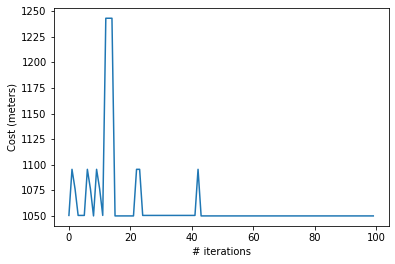

In [9]:
plt.xlabel("# iterations")
plt.ylabel("Cost (meters)")
plt.plot(states)
plt.show()

Unlike the strictly down-sloping graphs from beam search or hill-climbing, simulated annealing allows for the exploration of "worse" results, which broadens the search space.

## Example: Simulated annealing and the Traveling Salesman Problem

The [travelling salesman problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) is one of the most famous examples of optimization.

Let's generate a random graph of size 25. At this scale, looking for an exact solution to the TSP problem is nearly impossible (and computationally expensive).

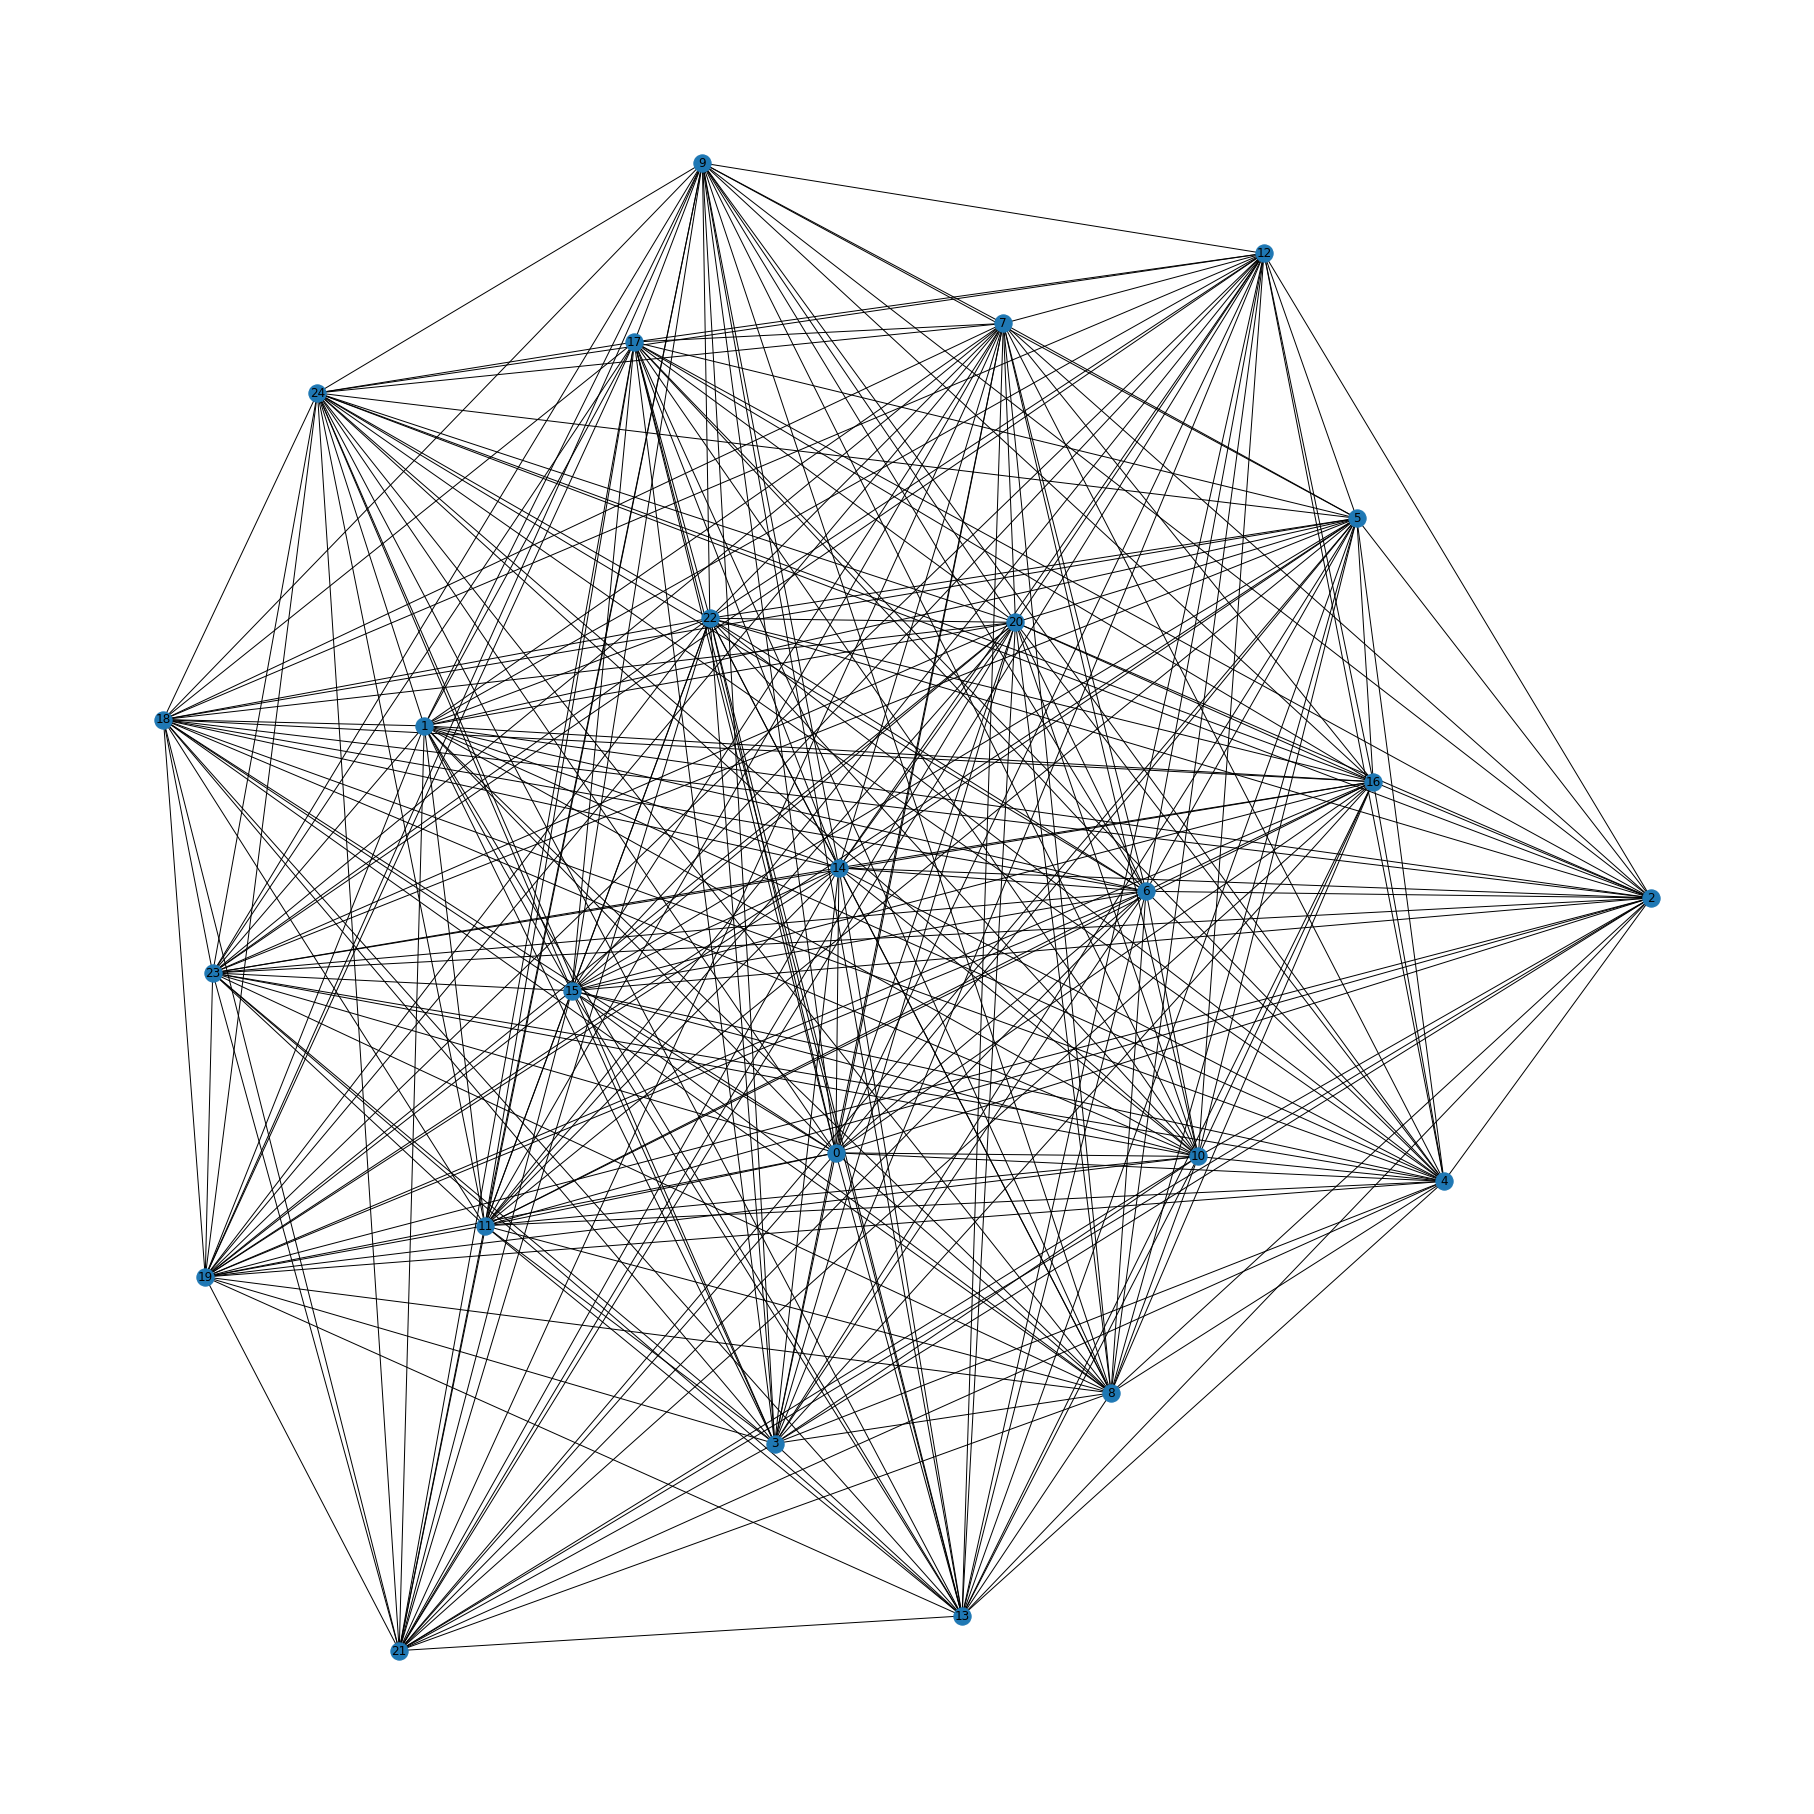

In [10]:
import networkx as nx
import random

G = nx.complete_graph(25)
for (u,v) in G.edges():
    G.edges[u,v]['weight'] = random.randint(0,10)

plt.figure(figsize=(25,25))
nx.draw(G, with_labels=True)
plt.show()

In [11]:
# a little utility function that finds the cost of a tour
def cost_of_tour(G, tour):
    cost = 0
    for u,v in zip(tour, tour[1:]):
        cost += G[u][v]['weight']
    cost += G[len(tour) - 1][0]['weight']
    return cost

schedule = exp_schedule(k=2000,lam=0.005, limit=100000)
num_of_iterations = 2000
states = []

current = [*G.nodes()]
random.shuffle(current)

for t in range(num_of_iterations):
    T = schedule(t)
    
    # generate 5 more paths to choose from
    neighbours = list()
    for _ in range(5):
        child = current[:]
        i = random.randint(0, len(child) - 1)
        j = random.randint(0, len(child) - 1)
        child[i], child[j] = child[j], child[i]
        neighbours.append(child)
    
    next_choice = random.choice(neighbours)
    
    delta_e = cost_of_tour(G, next_choice) - cost_of_tour(G, current)  # difference of cost
    if delta_e < 0 or probability(np.exp(-1 * delta_e)/ (T)): # getting closer to the goal
        current = next_choice
    states.append(cost_of_tour(G, current))


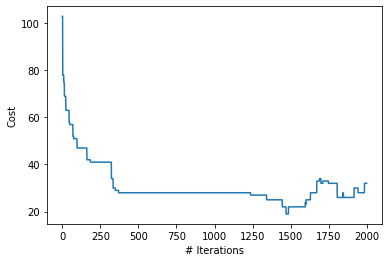

[15, 8, 24, 1, 5, 9, 11, 13, 12, 14, 2, 19, 7, 3, 22, 21, 18, 0, 20, 23, 10, 6, 16, 17, 4] = 32


In [12]:
plt.xlabel("# Iterations")
plt.ylabel("Cost")
plt.plot(states)
plt.show()
print(current, "=",cost_of_tour(G,current))